# DL Competition 3 Report

Team 09

組員：110062209 簡晟棋、110060032 蔡翔峯、110062226 王韋翔、110062314 楊琮熹

## Text Encoder

### For Diffusion Model
- 在Data Processing的部分，我們首先將助教提供的caption先還原成句子，接著再將這些句子輸入到pretrained model得到embedding跟attention mask，作為之後diffusion model的輸入。
- 在pretrained model的選擇上，我們使用了`clip-ViT-L-14`，利用clip在文字與圖像上優秀的處理能力，得以從text中extract出大量的資訊。

### For GAN
- 對於GAN來說，我們一樣是先將caption還原成句子，再輸入到pretrained model，不過由於GAN中我們沒有設計attention的機制，因此就只有簡單的將embedding取出。
- 在pretrained model的選擇上，我們使用了`all-mpnet-base-v2`。

## Data Augmentation

- 在data augmentation上，由於助教提供的data中，每一個image都有數個caption作為對應，為了增加data數量，我們將所有caption都轉換過後，將轉換過後的embedding跟attention mask都放入dataset中。
- 然而這樣會導致同一張image重複出現，因此我們額外對image進行crop跟flip，藉此來增加image多樣性。

## Method I: Diffusion Model

### Gaussian diffusion
- 在ddpm中，我們利用Gaussian Diffusion作為增加noise跟denoise的核心算法
- 在一開始時，我們針對輸入的beta，首先利用linear schedule，計算出每一個time step的beta，接著透過一系列計算，得到我們所需的alpha、beta的各個結果。
- 在增加noise的部分，我們直接根據公式，得到time step對應的 $\sqrt{\bar{\alpha}^{(t)}}$ 跟 $\sqrt{1 - \bar{\alpha}^{(t)}}$，接著計算 $x^{(t)} = \sqrt{\bar{\alpha}^{(t)}} * x^{(0)} + \sqrt{1 - \bar{\alpha}^{(t)}} * \epsilon$ 即可
- 在denoise的部分，一樣參考公式，先預測 $x^{(0)}$ 的結果，接著利用 $x^{(t)}$ 跟 $x^{(0)}$ 當作參數，去計算 $Q(x^{(t-1)}|x^{(t)}, x^{(0)})$ 即可

### U-Net
- 我們參考paper，首先對於輸入的image進行convolution，對time step計算embedding後，將其輸入到U-Net的架構中。
- 在U-Net的架構中，我們額外設計了三個Block：
  - Residual Block用來將time embedding輸入到計算結果內，並持續對input做convolution，同時增加shortcut connection來保留原本input的資訊。
  - Self-Attention Block則是在先前convolution計算後的convolution blocks達到一定resolution後(16x16 in the paper)，用來做blocks之間的資訊交換。
  - Cross-Attention Block則是用來實現conditional generation，使用中間activation的輸出，去得到text embedding的資訊，藉此來生成我們想要的圖片。
- 此外，我們亦參考paper加入了Group Normalization來幫助training，以及增加Dropout避免overfitting。
- 最後就是利用U-Net來預測noise。

### Diffusion Model
- 我們參考paper，設計ddpm的架構。在training的過程中，會利用EMA(exponential moving average)的方式去更新我們的network。對於輸入的image，我們首先隨機sample time step，利用Gaussian Diffusion增加noise，接著利用training network去預測noise並更新training network。最後再用EMA的方式更新predict network的weights。
- 在generate中，對於每一個time step，我們會利用predict network去predice noise，接著利用Gaussian Diffusion進行denoise。

## Method II: GAN

### Model

#### DCGAN

- 在DCGAN中，我們嘗試在Generator中加入deconvolution layer，在Discriminator中加入convolution layer，試圖利用CNN的layer來幫助解析跟生成圖片。
- 由於DCGAN原本的設計中並沒有conditional的機制，因此我們在Generator中，會先將text embedding透過一層layer轉換後，跟noise接在一起後，再輸入到後面的layer輸出圖片；在Discriminator中，我們則是分別將text embedding跟image分別透過dense layer跟conv layer轉換後，接在一起再透過後面的layer進行判斷。
- 不過實驗後發現，生成的image有時候會有格子狀的雜訊，因此我們也嘗試過將Generator的decov layer替換成upsampling layer。

#### Stack GAN
- 在Stack GAN中，我們分為兩個Stage來生成圖片，在Stage I中會先生成64\*64的小圖片，在Stage II中再透過小圖片生成128\*128的大圖，透過這種方式來產生清晰的大圖片。
- 在Stage I中，Generator跟Discriminator我們直接使用跟DCGAN一樣的架構，用來生成64\*64的小圖片。
- 在Stage II中，Generator會將image做embedding用來替代noise，接著將text跟image的embedding接在一起，通過數個Residual Blocks，最後再用upsampling layer得到image；而Discriminator則跟Stage I類似，一樣是將text embedding跟image轉換後，再相接輸入到後面的layer進行判斷。

### Other Techniques

#### WGAN-GP
- 我們透過WGAN-GP的方式來幫助Training，`WGAN`的架構下Discriminator輸出的不再是real / fake的類別，而是用regression的方式輸出真假的score，藉此來增加performance。
- 不過為了避免Discriminator崩潰，`WGAN`在Discriminator增加了clip限制每次update的幅度，而在`WGAN-GP`則改成計算gradient來進行Penalty。

#### Conditioning Augmentation
- 在Conditioning Augmentation中，對於一個text embedding我們會額外train一個model輸出他的分布（mean and variance），再sample出新的embedding，藉此來增加output的多樣性。
- 對於這個model，我們會計算它的KLloss，乘以常數$\lambda$加回原本的loss來做update。

#### GAN-CLS-INT
- 在`CLS`中，對於每個data，我們會額外sample一個wrong caption，輸入到Generater中並讓Discriminator判斷，之後update Discriminator讓其可以輸出fake label，藉此來讓Discriminator可以學習到分辨不同的caption生成出的圖。
- 在`INT`中，對於每個data，我們會將該data的text embedding跟wrong caption的text embedding做interpolation後輸入到Generator並讓Discriminator判斷，update Generator讓其可以騙過Discriminator，希望藉此可以讓Generator可以學到連續的image distribution。

#### Learning rate scheduling
- 在learning rate上，我們採用了Exponential Decay的scheduling，讓learning rate可以在training的過程中漸漸縮小，藉此來盡可能逼近optimal solution。

## Conclusion
- 我們原先除了diffusion model以外，也嘗試了GAN的方法，在model設計上，嘗試了DCGAN、StackGAN等等，在Optimization上，嘗試了wgan-gp、gan-cls-int、Conditioning Augmentation...等方法。並體會到GAN有多麼難train，比方說在不使用wgan-gp的情況下，連花朵的輪廓都難以生成出來。
- 另外，在diffusion model上，也並非一帆風順，原先我們嘗試lab 13中ddim的方法，卻發現最後生成出來的圖有一定的極限，分數無法再繼續上升，因此我們後來改使用ddpm後便成功超過上限。只是換ddpm之後一方面generate速度太慢，因此需花費更久的時間去評估結果好壞，另一方面我們發現設計出來的ddpm有overfitting的問題，因此我們加上Dropout跟weight decay嘗試避免，最終才得到現在的結果。

## Generated Image

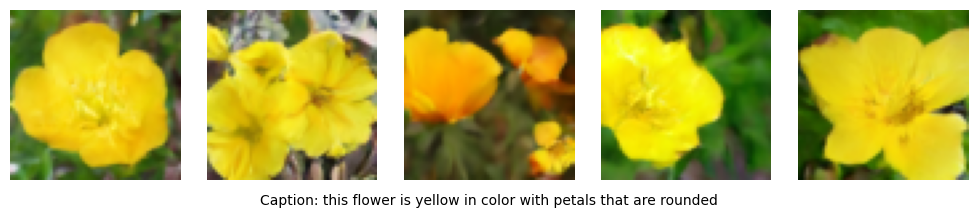

In [5]:
# from IPython.display import Image
# Image(filename = 'output1.png')

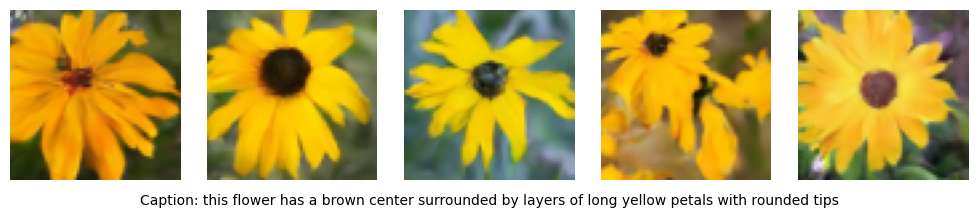

In [6]:
# Image(filename = 'output2.png')

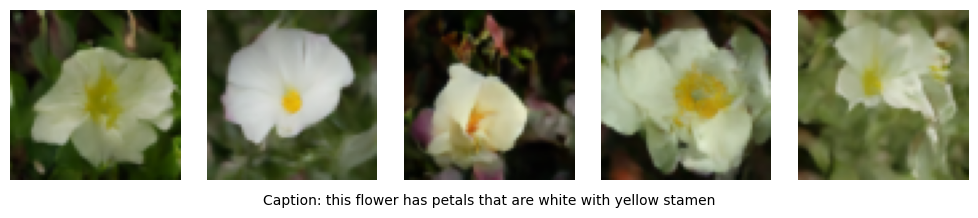

In [7]:
# Image(filename = 'output3.png')

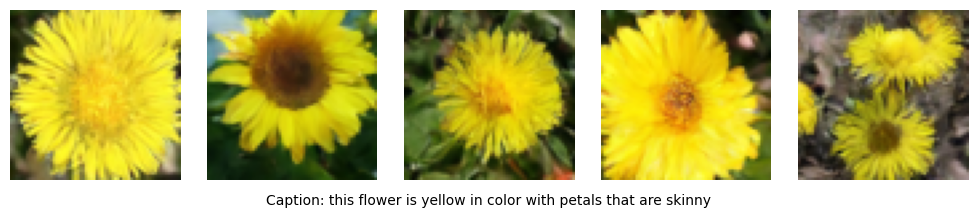

In [8]:
# Image(filename = 'output4.png')

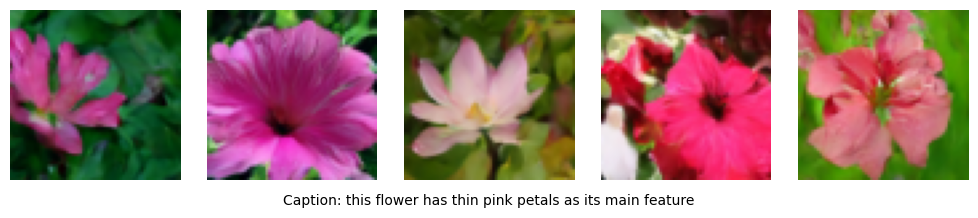

In [9]:
# Image(filename = 'output5.png')